In [1]:
!mkdir data

In [2]:
%pip install -q matplotlib numpy torch torchaudio torchvision scikit-learn seaborn google.cloud.storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00


In [3]:
# Adjust classes in src/config.py
from src.config import CLASSES

In [4]:
# Adjust parameter here
data_dir = "data"
training_size = 0.8
batch_size = 32
num_epochs = 5

In [5]:
label2id = {}
id2label = {}
for i, label in enumerate(CLASSES):
  label2id[label] = i
  id2label[i] = label

In [6]:
from google.cloud import storage

def download_public_file(bucket_name, source_blob_name, destination_file_name):
    """Downloads a public blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client.create_anonymous_client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Downloaded public blob {} from bucket {} to {}.".format(
            source_blob_name, bucket.name, destination_file_name
        )
    )

In [7]:
for item in CLASSES:
  download_public_file("quickdraw_dataset", f"full/numpy_bitmap/{item}.npy", f"{data_dir}/{item}.npy")

Downloaded public blob full/numpy_bitmap/book.npy from bucket quickdraw_dataset to data/book.npy.
Downloaded public blob full/numpy_bitmap/door.npy from bucket quickdraw_dataset to data/door.npy.
Downloaded public blob full/numpy_bitmap/envelope.npy from bucket quickdraw_dataset to data/envelope.npy.
Downloaded public blob full/numpy_bitmap/leaf.npy from bucket quickdraw_dataset to data/leaf.npy.
Downloaded public blob full/numpy_bitmap/pants.npy from bucket quickdraw_dataset to data/pants.npy.
Downloaded public blob full/numpy_bitmap/lightning.npy from bucket quickdraw_dataset to data/lightning.npy.
Downloaded public blob full/numpy_bitmap/diamond.npy from bucket quickdraw_dataset to data/diamond.npy.
Downloaded public blob full/numpy_bitmap/circle.npy from bucket quickdraw_dataset to data/circle.npy.
Downloaded public blob full/numpy_bitmap/triangle.npy from bucket quickdraw_dataset to data/triangle.npy.
Downloaded public blob full/numpy_bitmap/key.npy from bucket quickdraw_dataset t

In [8]:
import matplotlib.pyplot as plt
import numpy as np

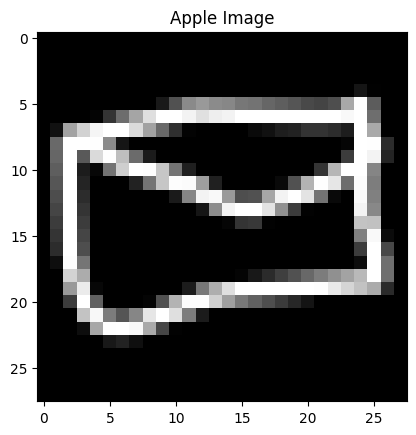

In [9]:
apple_data = np.load("data/envelope.npy")

# Display the first image from the apple data
plt.imshow(apple_data[3].reshape(28, 28), cmap='gray')
plt.title("Apple Image")
plt.show()

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class QuickDrawDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform
        self.data = []
        self.labels = []

        for i, class_name in enumerate(classes):
            file_path = f"{data_dir}/{class_name}.npy"
            class_data = np.load(file_path)
            self.data.extend(class_data)
            self.labels.extend([i] * len(class_data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28).astype(np.float32)  # Reshape to 28x28
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


dataset = QuickDrawDataset(f"{data_dir}", CLASSES)
train_size = int(training_size * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
import torch.nn as nn
from src.model import QuickDraw

# Create an instance of the model
model = QuickDraw(num_classes=len(CLASSES))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

QuickDraw(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=5408, out_features=12, bias=True)
)

In [12]:
from sklearn.metrics import accuracy_score # Import accuracy_score

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_labels = []  # Store all labels for the epoch
    all_predictions = [] # Store all predictions for the epoch

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.unsqueeze(1)  # Add channel dimension for CNN

        # Move inputs and labels to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions for accuracy calculation
        _, predicted = torch.max(outputs.data, 1)

        # Move labels and predictions to CPU and store for epoch accuracy
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * accuracy_score(all_labels, all_predictions) # Use accuracy_score

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%")

print("Finished Training")

Epoch [1/5], Loss: 1.3179468059488904, Accuracy: 85.6075572866925%
Epoch [2/5], Loss: 0.3424266306805734, Accuracy: 91.04136626654932%
Epoch [3/5], Loss: 0.29764031204118163, Accuracy: 92.11445790653109%
Epoch [4/5], Loss: 0.28149805994787286, Accuracy: 92.54906275163385%
Epoch [5/5], Loss: 0.27249125626481097, Accuracy: 92.78025380298746%
Finished Training


Accuracy: 0.9239433718469692
F1 Score: 0.9240227705753792
Recall: 0.9239433718469692


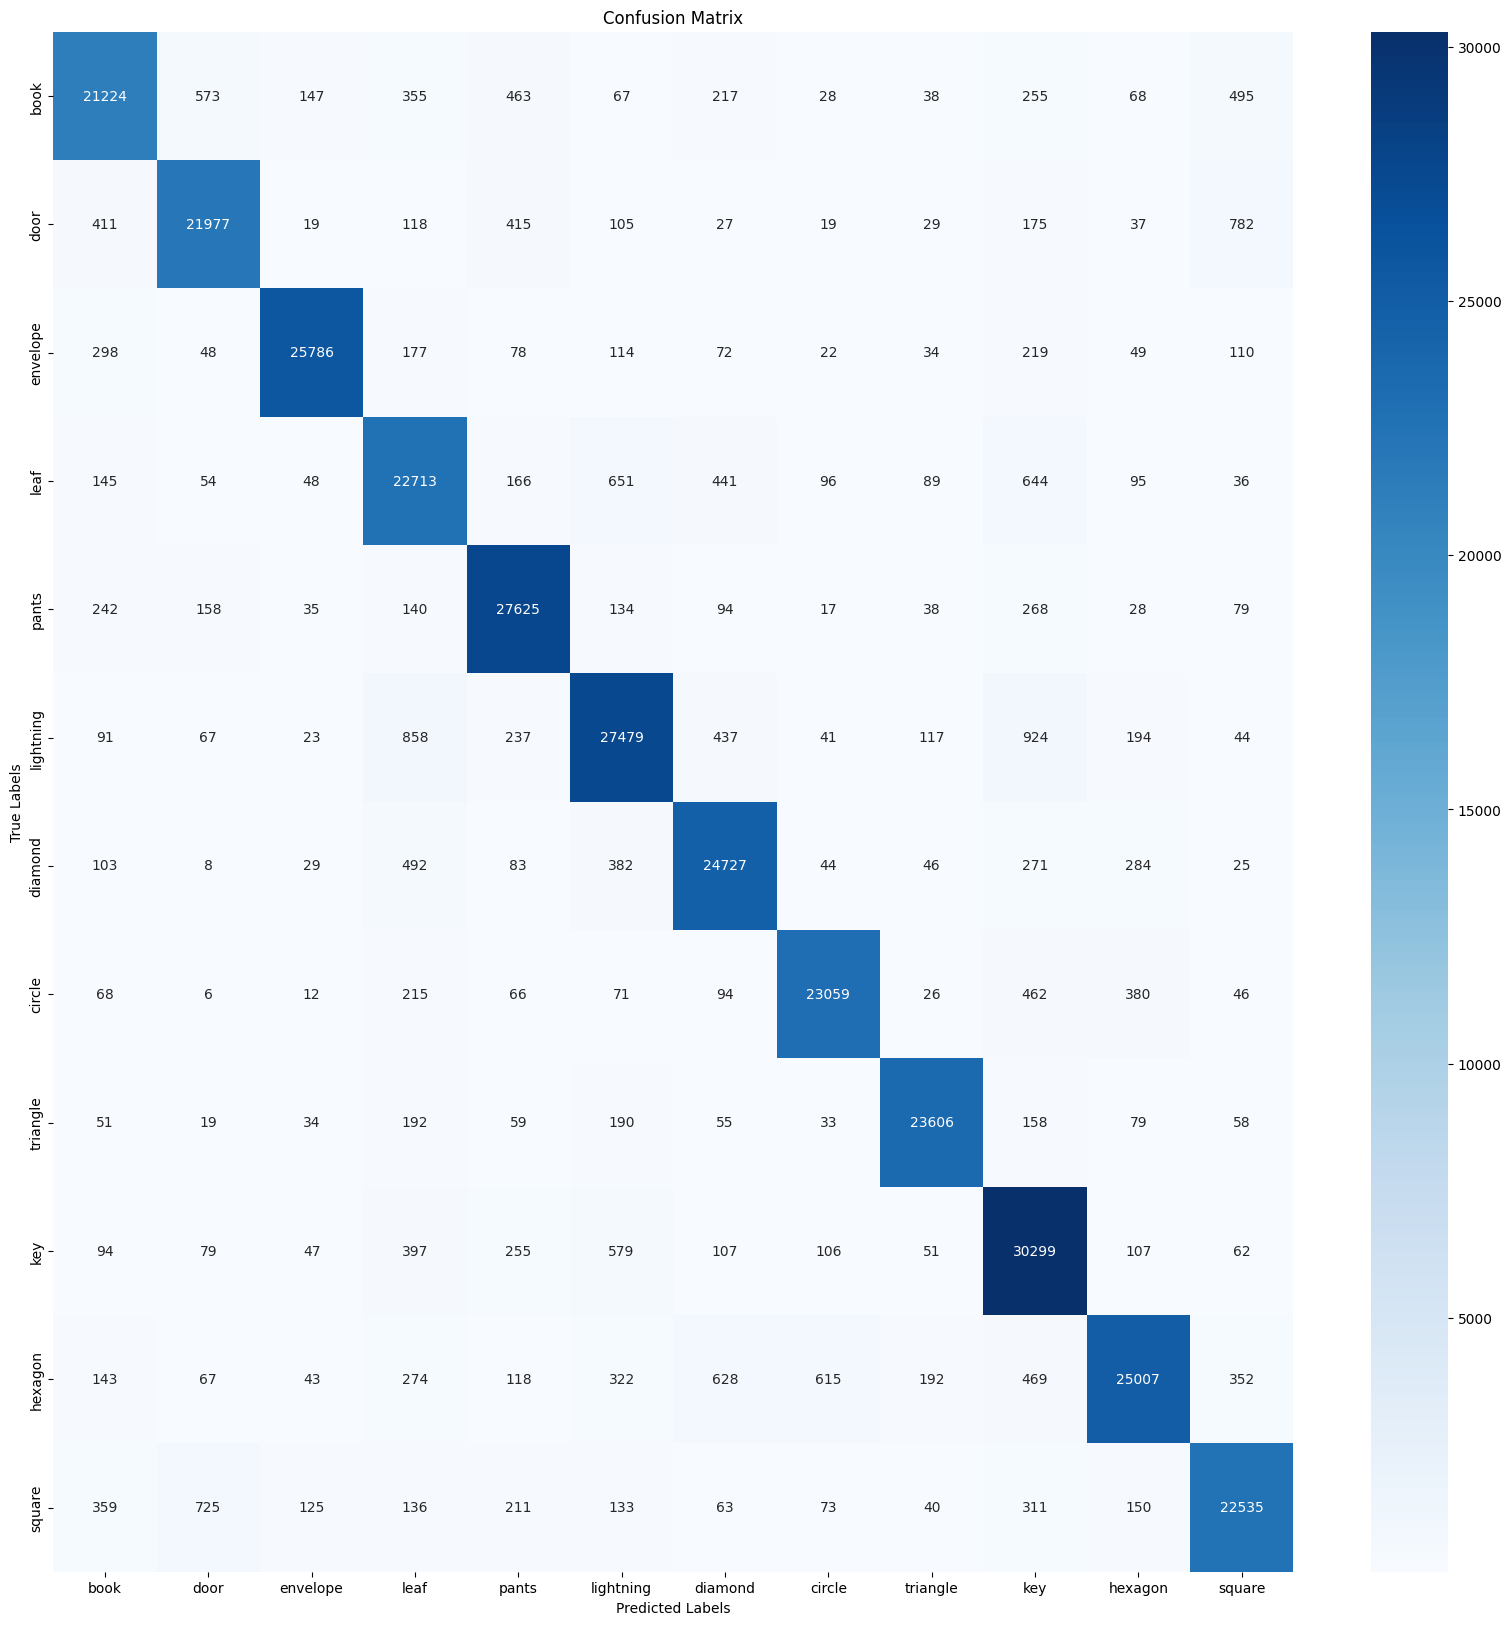

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns

# Evaluation
model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [14]:
import torch
torch.save(model.state_dict(), 'quickdraw_model.pth')
print("Model saved")

Model saved
